# S&P 500 Stock Market Analysis: Fama-French Factor Strategies

This notebook presents a comprehensive analysis of S&P 500 stock market trends using the Fama-French Cross-Sectional Factor Model - a traditional quantitative finance approach using momentum, volatility, liquidity, and size factors.

## Notebook Structure

- **Phase 1**: Environment Setup and Data Collection
- **Phase 2**: Data Preprocessing and Feature Engineering
- **Phase 3**: Fama-French Factor Model Implementation and Strategy Comparison

## Technical Stack

- **PySpark and Spark SQL**: Distributed data processing for large-scale financial data
- **CUDA/GPU Optimization**: Hardware acceleration for computationally intensive operations
- **yfinance**: S&P 500 historical data retrieval
- **pandas-datareader**: Fama-French factor data from Ken French's data library

## Phase 1: Environment Setup and Data Collection

This phase establishes the computational environment with GPU/CUDA optimization, initializes PySpark for distributed processing, and collects S&P 500 constituent data from Yahoo Finance.

### 1.1 Import Required Libraries and GPU Detection

The following cell imports all necessary libraries and performs GPU/CUDA availability checks. GPU acceleration is utilized for:
- CuPy: GPU-accelerated numerical computations
- cuDF: GPU DataFrame operations (when available)

In [2]:
# =============================================================================
# IMPORTS AND GPU DETECTION
# =============================================================================

import os
import sys
import time
import random
import warnings
from datetime import datetime, timedelta
from pathlib import Path

# Core data processing libraries
import numpy as np
import pandas as pd

# Financial data retrieval
import yfinance as yf

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical modeling
import statsmodels.api as sm

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# -----------------------------------------------------------------------------
# GPU/CUDA Detection and Configuration
# -----------------------------------------------------------------------------
GPU_AVAILABLE = False
CUPY_AVAILABLE = False
CUDF_AVAILABLE = False

# Check for PyTorch GPU support (optional for this notebook)
try:
    import torch
    import torch.nn as nn
    GPU_AVAILABLE = torch.cuda.is_available()
    if GPU_AVAILABLE:
        print(f"GPU Detected: {torch.cuda.get_device_name(0)}")
        print(f"VRAM Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
except (ImportError, OSError) as e:
    print(f"Note: PyTorch not available ({type(e).__name__}). GPU operations will use CPU fallback.")

# Check for CuPy (GPU-accelerated NumPy)
try:
    import cupy as cp
    CUPY_AVAILABLE = True
    print("CuPy available for GPU-accelerated numerical operations")
except ImportError:
    CUPY_AVAILABLE = False
    print("Note: CuPy not installed. Using NumPy for computations.")

# Check for cuDF (GPU DataFrames)
try:
    import cudf
    CUDF_AVAILABLE = True
    print("cuDF available for GPU DataFrame operations")
except ImportError:
    CUDF_AVAILABLE = False
    print("Note: cuDF not installed. Using Pandas for DataFrames.")

# Scikit-learn for metrics and preprocessing
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler

# Fama-French data retrieval
try:
    from pandas_datareader import data as pdr
except ImportError:
    pdr = None
    print("Note: pandas_datareader not installed. Fama-French factors will require manual download.")

print("\n" + "="*60)
print("ENVIRONMENT CONFIGURATION SUMMARY")
print("="*60)
print(f"GPU Acceleration:     {'Enabled' if GPU_AVAILABLE else 'Disabled'}")
print(f"CuPy (GPU NumPy):     {'Available' if CUPY_AVAILABLE else 'Not Available'}")
print(f"cuDF (GPU Pandas):    {'Available' if CUDF_AVAILABLE else 'Not Available'}")
print("="*60)

Note: PyTorch not available (OSError). GPU operations will use CPU fallback.
Note: CuPy not installed. Using NumPy for computations.
Note: cuDF not installed. Using Pandas for DataFrames.

ENVIRONMENT CONFIGURATION SUMMARY
GPU Acceleration:     Disabled
CuPy (GPU NumPy):     Not Available
cuDF (GPU Pandas):    Not Available

ENVIRONMENT CONFIGURATION SUMMARY
GPU Acceleration:     Disabled
CuPy (GPU NumPy):     Not Available
cuDF (GPU Pandas):    Not Available


### 1.2 Initialize PySpark Session with GPU Optimizations

PySpark is configured with the following optimizations:
- Arrow-based data transfer between Pandas and Spark for improved performance
- Adaptive query execution for dynamic optimization
- Memory configuration tuned for large-scale financial data processing

In [3]:
# =============================================================================
# PYSPARK SESSION INITIALIZATION
# =============================================================================

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window

# Spark configuration with performance optimizations
spark_config = {
    'spark.sql.shuffle.partitions': '8',
    'spark.sql.execution.arrow.pyspark.enabled': 'true',      # Arrow for Pandas conversion
    'spark.sql.adaptive.enabled': 'true',                      # Adaptive query execution
    'spark.sql.adaptive.coalescePartitions.enabled': 'true',   # Dynamic partition coalescing
    'spark.sql.adaptive.skewJoin.enabled': 'true',             # Handle skewed data
    'spark.executor.memory': '8g',
    'spark.driver.memory': '8g',
    'spark.memory.fraction': '0.8',                            # Memory allocation for execution
}

# Build Spark session
spark_builder = SparkSession.builder \
    .master('local[*]') \
    .appName('sp500_factor_analysis')

for key, value in spark_config.items():
    spark_builder = spark_builder.config(key, value)

spark = spark_builder.getOrCreate()

print("="*60)
print("SPARK SESSION INITIALIZED")
print("="*60)
print(f"Parallelism:          {spark.sparkContext.defaultParallelism} partitions")
print(f"Arrow Optimization:   Enabled")
print(f"Adaptive Execution:   Enabled")
print(f"GPU Acceleration:     {'Enabled' if GPU_AVAILABLE else 'Not Available'}")
print("="*60)

SPARK SESSION INITIALIZED
Parallelism:          16 partitions
Arrow Optimization:   Enabled
Adaptive Execution:   Enabled
GPU Acceleration:     Not Available


### 1.3 Set Random Seeds for Reproducibility

Setting consistent random seeds across all libraries ensures reproducible results for:
- NumPy random operations
- Random module operations

In [4]:
# =============================================================================
# RANDOM SEED CONFIGURATION
# =============================================================================

RANDOM_SEED = 42

# Python random
random.seed(RANDOM_SEED)

# NumPy
np.random.seed(RANDOM_SEED)

# PyTorch (CPU and GPU)
if 'torch' in sys.modules:
    torch.manual_seed(RANDOM_SEED)
    if GPU_AVAILABLE:
        torch.cuda.manual_seed(RANDOM_SEED)
        torch.cuda.manual_seed_all(RANDOM_SEED)
        # Ensure deterministic behavior on GPU
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

print(f"Random seed set to: {RANDOM_SEED}")

Random seed set to: 42


### 1.4 Define GPU Utility Functions

These utility functions provide GPU-accelerated implementations of common numerical operations. Each function falls back to CPU (NumPy/Pandas) when GPU is not available.

In [5]:
# =============================================================================
# GPU-ACCELERATED UTILITY FUNCTIONS
# =============================================================================

def gpu_zscore_normalize(data_np, axis=0):
    """
    GPU-accelerated z-score normalization.
    Falls back to NumPy if CuPy is not available.
    
    Parameters:
        data_np: numpy array to normalize
        axis: axis along which to normalize
    
    Returns:
        Normalized array
    """
    if CUPY_AVAILABLE:
        try:
            data_cp = cp.asarray(data_np)
            mean = cp.mean(data_cp, axis=axis, keepdims=True)
            std = cp.std(data_cp, axis=axis, keepdims=True)
            normalized = (data_cp - mean) / (std + 1e-8)
            return cp.asnumpy(normalized)
        except Exception as e:
            pass  # Fall back to CPU
    
    # CPU fallback
    return (data_np - np.mean(data_np, axis=axis, keepdims=True)) / \
           (np.std(data_np, axis=axis, keepdims=True) + 1e-8)


def gpu_accelerated_corr(df, cols):
    """
    GPU-accelerated correlation matrix computation.
    Falls back to Pandas if CuPy is not available.
    """
    if CUPY_AVAILABLE:
        try:
            data_cp = cp.asarray(df[cols].values)
            data_std = (data_cp - cp.mean(data_cp, axis=0)) / (cp.std(data_cp, axis=0) + 1e-8)
            corr_matrix = (data_std.T @ data_std) / len(data_std)
            return pd.DataFrame(cp.asnumpy(corr_matrix), index=cols, columns=cols)
        except Exception as e:
            pass  # Fall back to CPU
    
    return df[cols].corr()


def gpu_cumprod(returns_np):
    """
    GPU-accelerated cumulative product for cumulative returns calculation.
    """
    if CUPY_AVAILABLE:
        try:
            returns_cp = cp.asarray(returns_np)
            return cp.asnumpy(cp.cumprod(1 + returns_cp) - 1)
        except Exception as e:
            pass  # Fall back to CPU
    
    return np.cumprod(1 + returns_np) - 1


def compute_perf_stats(returns_series, periods_per_year=252):
    """
    Compute comprehensive performance statistics for a return series.
    
    Parameters:
        returns_series: pandas Series of daily returns
        periods_per_year: number of trading periods per year (252 for daily)
    
    Returns:
        Dictionary containing performance metrics
    """
    ret = returns_series.dropna()
    if ret.empty or len(ret) < 2:
        return None
    
    cum = (1 + ret).cumprod()
    total_return = cum.iloc[-1] - 1
    
    # Annualized metrics
    num_years = len(ret) / periods_per_year
    ann_return = (cum.iloc[-1] ** (1 / num_years)) - 1
    ann_vol = ret.std() * (periods_per_year ** 0.5)
    
    # Sharpe ratio (assuming 0% risk-free rate)
    sharpe = (ret.mean() * periods_per_year) / ann_vol if ann_vol > 0 else 0
    
    # Maximum drawdown
    running_max = cum.expanding().max()
    drawdown = (cum - running_max) / running_max
    max_dd = drawdown.min()
    
    # Win rate
    win_rate = (ret > 0).sum() / len(ret)
    
    return {
        'total_return': total_return,
        'ann_return': ann_return,
        'ann_vol': ann_vol,
        'sharpe': sharpe,
        'max_drawdown': max_dd,
        'win_rate': win_rate,
        'duration_years': num_years,
        'num_days': len(ret),
        'cum_return': cum
    }


print("GPU utility functions loaded successfully")

GPU utility functions loaded successfully


### 1.5 Project Configuration

This section defines the project configuration including:
- Date range for data collection (10 years: 2014-12-08 to 2024-12-08)
- Complete list of S&P 500 tickers plus SPY as benchmark
- Feature engineering parameters (lag periods, moving averages, RSI, volatility windows)
- Model training parameters (train/test split, lookback window)
- Strategy parameters (z-score threshold, Kelly fraction)
- Output directory path for data storage

In [ ]:
# =============================================================================
# PROJECT CONFIGURATION
# =============================================================================

class Config:
    # Data Collection - 10 years of data
    START_DATE = '2014-12-08'
    END_DATE = '2024-12-08'
    INTERVAL = '1d'  # Daily bars

    # Tickers - S&P500 stocks + SPY for correlation benchmark
    TICKERS = [
        'SPY',  # S&P 500 ETF for correlation analysis
        'MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A',
        'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL',
        'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT',
        'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL',
        'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK',
        'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BK', 'BBWI',
        'BAX', 'BDX', 'BRK.B', 'BBY', 'TECH', 'BIIB', 'BLK', 'BX', 'BA', 'BKNG',
        'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG',
        'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT',
        'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CF', 'CHRW',
        'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS',
        'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA',
        'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CTVA',
        'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'CVS', 'DHI', 'DHR', 'DRI',
        'DVA', 'DAY', 'DE', 'DAL', 'XRAY', 'DVN', 'DXCM', 'FANG', 'DLR', 'DFS',
        'DG', 'DLTR', 'D', 'DPZ', 'DOV', 'DOW', 'DTE', 'DUK', 'DD', 'EMN',
        'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'ELV', 'LLY', 'EMR', 'ENPH',
        'ETR', 'EOG', 'EPAM', 'EQT', 'EFX', 'EQIX', 'EQR', 'ESS', 'EL', 'ETSY',
        'EG', 'EVRG', 'ES', 'EXC', 'EXPE', 'EXPD', 'EXR', 'XOM', 'FFIV', 'FDS',
        'FICO', 'FAST', 'FRT', 'FDX', 'FIS', 'FITB', 'FSLR', 'FE', 'FI', 'FMC',
        'F', 'FTNT', 'FTV', 'FOXA', 'FOX', 'BEN', 'FCX', 'GRMN', 'IT', 'GE',
        'GEHC', 'GEN', 'GNRC', 'GD', 'GIS', 'GM', 'GPC', 'GILD', 'GL', 'GPN',
        'GS', 'HAL', 'HIG', 'HAS', 'HCA', 'DOC', 'HSIC', 'HSY', 'HES', 'HPE',
        'HLT', 'HOLX', 'HD', 'HON', 'HRL', 'HST', 'HWM', 'HPQ', 'HUBB', 'HUM',
        'HBAN', 'HII', 'IBM', 'IEX', 'IDXX', 'ITW', 'ILMN', 'INCY', 'IR', 'PODD',
        'INTC', 'ICE', 'IFF', 'IP', 'IPG', 'INTU', 'ISRG', 'IVZ', 'INVH', 'IQV',
        'IRM', 'JBHT', 'JBL', 'JKHY', 'J', 'JNJ', 'JCI', 'JPM', 'JNPR', 'K',
        'KVUE', 'KDP', 'KEY', 'KEYS', 'KMB', 'KIM', 'KMI', 'KLAC', 'KHC', 'KR',
        'LHX', 'LH', 'LRCX', 'LW', 'LVS', 'LDOS', 'LEN', 'LNC', 'LIN', 'LYV',
        'LKQ', 'LMT', 'L', 'LOW', 'LULU', 'LYB', 'MTB', 'MRO', 'MPC', 'MKTX',
        'MAR', 'MMC', 'MLM', 'MAS', 'MA', 'MTCH', 'MKC', 'MCD', 'MCK', 'MDT',
        'MRK', 'META', 'MET', 'MTD', 'MGM', 'MCHP', 'MU', 'MSFT', 'MAA', 'MRNA',
        'MHK', 'MOH', 'TAP', 'MDLZ', 'MPWR', 'MNST', 'MCO', 'MS', 'MOS', 'MSI',
        'MSCI', 'NDAQ', 'NTAP', 'NFLX', 'NEM', 'NWSA', 'NWS', 'NEE', 'NKE', 'NI',
        'NDSN', 'NSC', 'NTRS', 'NOC', 'NCLH', 'NRG', 'NUE', 'NVDA', 'NVR', 'NXPI',
        'ORLY', 'OXY', 'ODFL', 'OMC', 'ON', 'OKE', 'ORCL', 'OTIS', 'PCAR', 'PKG',
        'PANW', 'PARA', 'PH', 'PAYX', 'PAYC', 'PYPL', 'PNR', 'PEP', 'PFE', 'PCG',
        'PM', 'PSX', 'PNW', 'PXD', 'PNC', 'POOL', 'PPG', 'PPL', 'PFG', 'PG',
        'PGR', 'PLD', 'PRU', 'PEG', 'PTC', 'PSA', 'PHM', 'QRVO', 'PWR', 'QCOM',
        'DGX', 'RL', 'RJF', 'RTX', 'O', 'REG', 'REGN', 'RF', 'RSG', 'RMD',
        'RVTY', 'RHI', 'ROK', 'ROL', 'ROP', 'ROST', 'RCL', 'SPGI', 'CRM', 'SBAC',
        'SLB', 'STX', 'SRE', 'NOW', 'SHW', 'SPG', 'SWKS', 'SJM', 'SNA', 'SOLV',
        'SO', 'LUV', 'SWK', 'SBUX', 'STT', 'STLD', 'STE', 'SYK', 'SMCI', 'SYF',
        'SNPS', 'SYY', 'TMUS', 'TROW', 'TTWO', 'TPR', 'TRGP', 'TGT', 'TEL', 'TDY',
        'TFX', 'TER', 'TSLA', 'TXN', 'TXT', 'TMO', 'TJX', 'TSCO', 'TT', 'TDG',
        'TRV', 'TRMB', 'TFC', 'TYL', 'TSN', 'USB', 'UBER', 'UDR', 'ULTA', 'UNP',
        'UAL', 'UPS', 'URI', 'UNH', 'UHS', 'VLO', 'VTR', 'VLTO', 'VRSN', 'VRSK',
        'VZ', 'VRTX', 'VFC', 'VTRS', 'VICI', 'V', 'VST', 'VMC', 'WRB', 'GWW',
        'WAB', 'WBA', 'WMT', 'DIS', 'WBD', 'WM', 'WAT', 'WEC', 'WFC', 'WELL',
        'WST', 'WDC', 'WY', 'WMB', 'WTW', 'WYNN', 'XEL', 'XYL', 'YUM', 'ZBRA', 'ZBH', 'ZTS'
    ]

    # Feature Engineering
    LAG_PERIODS = [1, 3, 5, 10]
    SMA_PERIODS = [20, 50, 200]
    RSI_PERIOD = 14
    VOLATILITY_WINDOW = 20
    CORRELATION_WINDOW = 60

    # Model Training
    TRAIN_SIZE = 0.7
    TEST_SIZE = 0.3
    LOOKBACK_WINDOW = 60  # For LSTM/CNN

    # Strategy Parameters
    MEAN_REVERSION_ZSCORE = 2.0
    KELLY_FRACTION = 0.25

    # Paths
    DATA_DIR = 'data'

    # Spark
    SPARK_APP_NAME = "StockPrediction"
    SPARK_MEMORY = "8g"

# Initialize configuration
config = Config()

# Create all necessary directories
for directory in [config.DATA_DIR, config.FEATURES_DIR, config.MODELS_DIR,
                   config.PREDICTIONS_DIR, config.RESULTS_DIR, config.PLOTS_DIR]:
    os.makedirs(directory, exist_ok=True)

# Create data directory
os.makedirs(config.DATA_DIR, exist_ok=True)

# Set global variables for backward compatibility
START_DATE = config.START_DATE
END_DATE = config.END_DATE
INTERVAL = config.INTERVAL
TICKERS = config.TICKERS

print("="*60)
print("CONFIGURATION LOADED")
print(f"Interval:             {config.INTERVAL}")
print(f"Tickers:              {len(config.TICKERS)} (including SPY benchmark)")
print(f"Date Range:           {config.START_DATE} to {config.END_DATE}")
print(f"Interval:             {config.INTERVAL}")
print(f"Train/Test Split:     {config.TRAIN_SIZE}/{config.TEST_SIZE}")

CONFIGURATION LOADED
Tickers:              503 (including SPY benchmark)
Date Range:           2014-12-08 to 2024-12-08
Interval:             1d
Train/Test Split:     0.7/0.3
Sample Tickers:       ['SPY', 'MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL']...
All output directories created


### 1.6 Download Historical Market Data

This section downloads historical OHLCV data for all configured tickers using the yfinance library. Key features:
- Clears any previous corrupted data before downloading
- Uses retry logic with exponential backoff for reliability
- Rate limiting to avoid API throttling
- Individual CSV files per ticker for resume capability
- Combines all data into a single prices.csv file for analysis

In [7]:
# =============================================================================
# HISTORICAL DATA DOWNLOAD (Using yf.Ticker method from gcn.ipynb)
# =============================================================================

import shutil
from pathlib import Path

# Output paths
data_dir = Path(config.DATA_DIR)
data_dir.mkdir(exist_ok=True)

COMBINED_CSV = data_dir / 'prices.csv'

# Clear previous data if exists
if COMBINED_CSV.exists():
    COMBINED_CSV.unlink()
    print(f"Removed previous data file: {COMBINED_CSV}")

def fetch_ticker_df(ticker: str) -> pd.DataFrame:
    """
    Downloads historical OHLCV data for a stock ticker from Yahoo Finance.
    Uses the same method as gcn.ipynb for reliability.
    
    Parameters:
        ticker: Stock ticker symbol
    
    Returns:
        DataFrame with OHLCV data, or empty DataFrame on failure
    """
    print(f"  Fetching {ticker}...", end=" ")
    try:
        # Use yf.Ticker with history() - same as gcn.ipynb
        tk = yf.Ticker(ticker)
        df = tk.history(
            start=START_DATE,
            end=END_DATE,
            interval=INTERVAL,
            auto_adjust=False
        )
        
        if df is None or df.empty:
            print("No data")
            return pd.DataFrame()
        
        # Handle multi-level columns if present
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)
        
        # Rename columns to lowercase (matching gcn.ipynb format)
        df = df.rename(columns={
            "Open": "open",
            "High": "high",
            "Low": "low",
            "Close": "close",
            "Adj Close": "adj_close",
            "Volume": "volume",
        })
        
        # Reset index to make date a column
        df.index.name = "date"
        df["ticker"] = ticker
        df = df.reset_index().sort_values("date")
        
        # Drop rows with all NaN price values
        price_cols = ["open", "high", "low", "close", "adj_close", "volume"]
        existing_price_cols = [c for c in price_cols if c in df.columns]
        df = df.dropna(subset=existing_price_cols, how="all")
        
        print(f"{len(df)} rows")
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        return pd.DataFrame()


# Download data for all tickers
all_data = []
failures = []
total = len(TICKERS)

print(f"Downloading data for {total} tickers...")
print(f"Date range: {START_DATE} to {END_DATE}")
print("-" * 60)

for i, ticker in enumerate(TICKERS):
    # Convert ticker format for Yahoo Finance (BRK.B -> BRK-B)
    yf_ticker = ticker.replace('.', '-')
    
    df = fetch_ticker_df(yf_ticker)
    
    if not df.empty:
        all_data.append(df)
    else:
        failures.append(ticker)
    
    # Rate limiting
    time.sleep(0.1)
    
    # Progress update every 50 tickers
    if (i + 1) % 50 == 0:
        print(f"--- Progress: {i + 1}/{total} tickers processed ---")

print("-" * 60)
print(f"Download complete.")
print(f"  - Success: {len(all_data)} tickers")
print(f"  - Failed:  {len(failures)} tickers")

if failures:
    print(f"  - Failed tickers: {failures[:20]}{'...' if len(failures) > 20 else ''}")

# Combine all data into single DataFrame and save
if all_data:
    raw_df = pd.concat(all_data, ignore_index=True)
    raw_df.to_csv(COMBINED_CSV, index=False)
    print(f"\nCombined CSV saved: {COMBINED_CSV}")
    print(f"  - Total rows: {len(raw_df):,}")
    print(f"  - Unique tickers: {raw_df['ticker'].nunique()}")
    print(f"  - Date range: {raw_df['date'].min()} to {raw_df['date'].max()}")
    print(f"  - File size: {COMBINED_CSV.stat().st_size / (1024*1024):.1f} MB")
else:
    print("ERROR: No data was downloaded successfully!")
    raw_df = pd.DataFrame()

Date range: 2014-12-08 to 2024-12-08
------------------------------------------------------------
  Fetching SPY... 2517 rows
  Fetching MMM... 2517 rows
  Fetching MMM... 2517 rows
  Fetching AOS... 2517 rows
  Fetching AOS... 2517 rows
  Fetching ABT... 2517 rows
  Fetching ABT... 2517 rows
  Fetching ABBV... 2517 rows
  Fetching ABBV... 2517 rows
  Fetching ACN... 2517 rows
  Fetching ACN... 2517 rows
  Fetching ADBE... 2517 rows
  Fetching ADBE... 2517 rows
  Fetching AMD... 2517 rows
  Fetching AMD... 2517 rows
  Fetching AES... 2517 rows
  Fetching AES... 2517 rows
  Fetching AFL... 2517 rows
  Fetching AFL... 2517 rows
  Fetching A... 2517 rows
  Fetching A... 2517 rows
  Fetching APD... 2517 rows
  Fetching APD... 2517 rows
  Fetching ABNB... 2517 rows
  Fetching ABNB... 1004 rows
  Fetching AKAM... 1004 rows
  Fetching AKAM... 2517 rows
  Fetching ALB... 2517 rows
  Fetching ALB... 2517 rows
  Fetching ARE... 2517 rows
  Fetching ARE... 2517 rows
  Fetching ALGN... 2517 rows
 

HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: ANSS"}}}
$ANSS: possibly delisted; no timezone found
$ANSS: possibly delisted; no timezone found


No data
  Fetching AON... 2517 rows
  Fetching APA... 2517 rows
  Fetching APA... 2517 rows
  Fetching AAPL... 2517 rows
  Fetching AAPL... 2517 rows
  Fetching AMAT... 2517 rows
  Fetching AMAT... 2517 rows
  Fetching APTV... 2517 rows
  Fetching APTV... 2517 rows
  Fetching ACGL... 2517 rows
  Fetching ACGL... 2517 rows
  Fetching ADM... 2517 rows
  Fetching ADM... 2517 rows
  Fetching ANET... 2517 rows
  Fetching ANET... 2517 rows
  Fetching AJG... 2517 rows
  Fetching AJG... 2517 rows
  Fetching AIZ... 2517 rows
  Fetching AIZ... 2517 rows
  Fetching T... 2517 rows
  Fetching T... 2517 rows
  Fetching ATO... 2517 rows
  Fetching ATO... 2517 rows
--- Progress: 50/503 tickers processed ---
  Fetching ADSK... 2517 rows
--- Progress: 50/503 tickers processed ---
  Fetching ADSK... 2517 rows
  Fetching ADP... 2517 rows
  Fetching ADP... 2517 rows
  Fetching AZO... 2517 rows
  Fetching AZO... 2517 rows
  Fetching AVB... 2517 rows
  Fetching AVB... 2517 rows
  Fetching AVY... 2517 rows
  

$CTLT: possibly delisted; no timezone found


No data
  Fetching CAT... 2517 rows
  Fetching CBOE... 2517 rows
  Fetching CBOE... 2517 rows
  Fetching CBRE... 2517 rows
  Fetching CBRE... 2517 rows
  Fetching CDW... 2517 rows
  Fetching CDW... 2517 rows
  Fetching CE... 2517 rows
  Fetching CE... 2517 rows
  Fetching COR... 2517 rows
  Fetching COR... 2517 rows
  Fetching CNC... 2517 rows
  Fetching CNC... 2517 rows
  Fetching CNP... 2517 rows
  Fetching CNP... 2517 rows
  Fetching CF... 2517 rows
  Fetching CF... 2517 rows
--- Progress: 100/503 tickers processed ---
  Fetching CHRW... 2517 rows
--- Progress: 100/503 tickers processed ---
  Fetching CHRW... 2517 rows
  Fetching CRL... 2517 rows
  Fetching CRL... 2517 rows
  Fetching SCHW... 2517 rows
  Fetching SCHW... 2517 rows
  Fetching CHTR... 2517 rows
  Fetching CHTR... 2517 rows
  Fetching CVX... 2517 rows
  Fetching CVX... 2517 rows
  Fetching CMG... 2517 rows
  Fetching CMG... 2517 rows
  Fetching CB... 2517 rows
  Fetching CB... 2517 rows
  Fetching CHD... 2517 rows
  Fe

$DFS: possibly delisted; no timezone found


No data
  Fetching DG... 2517 rows
  Fetching DLTR... 2517 rows
  Fetching DLTR... 2517 rows
  Fetching D... 2517 rows
  Fetching D... 2517 rows
  Fetching DPZ... 2517 rows
  Fetching DPZ... 2517 rows
  Fetching DOV... 2517 rows
  Fetching DOV... 2517 rows
  Fetching DOW... 2517 rows
  Fetching DOW... 1441 rows
  Fetching DTE... 1441 rows
  Fetching DTE... 2517 rows
  Fetching DUK... 2517 rows
  Fetching DUK... 2517 rows
  Fetching DD... 2517 rows
  Fetching DD... 2517 rows
  Fetching EMN... 2517 rows
  Fetching EMN... 2517 rows
  Fetching ETN... 2517 rows
  Fetching ETN... 2517 rows
  Fetching EBAY... 2517 rows
  Fetching EBAY... 2517 rows
  Fetching ECL... 2517 rows
  Fetching ECL... 2517 rows
  Fetching EIX... 2517 rows
  Fetching EIX... 2517 rows
  Fetching EW... 2517 rows
  Fetching EW... 2517 rows
  Fetching EA... 2517 rows
  Fetching EA... 2517 rows
  Fetching ELV... 2517 rows
  Fetching ELV... 2517 rows
  Fetching LLY... 2517 rows
  Fetching LLY... 2517 rows
  Fetching EMR... 2

$HES: possibly delisted; no timezone found


No data
  Fetching HPE... 2300 rows
  Fetching HLT... 2300 rows
  Fetching HLT... 2517 rows
  Fetching HOLX... 2517 rows
  Fetching HOLX... 2517 rows
  Fetching HD... 2517 rows
  Fetching HD... 2517 rows
  Fetching HON... 2517 rows
  Fetching HON... 2517 rows
  Fetching HRL... 2517 rows
  Fetching HRL... 2517 rows
  Fetching HST... 2517 rows
  Fetching HST... 2517 rows
  Fetching HWM... 2517 rows
  Fetching HWM... 2038 rows
  Fetching HPQ... 2038 rows
  Fetching HPQ... 2517 rows
  Fetching HUBB... 2517 rows
  Fetching HUBB... 2517 rows
  Fetching HUM... 2517 rows
  Fetching HUM... 2517 rows
  Fetching HBAN... 2517 rows
  Fetching HBAN... 2517 rows
  Fetching HII... 2517 rows
  Fetching HII... 2517 rows
  Fetching IBM... 2517 rows
  Fetching IBM... 2517 rows
  Fetching IEX... 2517 rows
  Fetching IEX... 2517 rows
  Fetching IDXX... 2517 rows
  Fetching IDXX... 2517 rows
  Fetching ITW... 2517 rows
  Fetching ITW... 2517 rows
  Fetching ILMN... 2517 rows
  Fetching ILMN... 2517 rows
  Fe

$JNPR: possibly delisted; no timezone found


No data
  Fetching K... 2517 rows
  Fetching KVUE... 2517 rows
  Fetching KVUE... 402 rows
  Fetching KDP... 402 rows
  Fetching KDP... 2517 rows
  Fetching KEY... 2517 rows
  Fetching KEY... 2517 rows
  Fetching KEYS... 2517 rows
  Fetching KEYS... 2517 rows
  Fetching KMB... 2517 rows
  Fetching KMB... 2517 rows
  Fetching KIM... 2517 rows
  Fetching KIM... 2517 rows
  Fetching KMI... 2517 rows
  Fetching KMI... 2517 rows
  Fetching KLAC... 2517 rows
  Fetching KLAC... 2517 rows
  Fetching KHC... 2517 rows
  Fetching KHC... 2374 rows
  Fetching KR... 2374 rows
  Fetching KR... 2517 rows
  Fetching LHX... 2517 rows
  Fetching LHX... 2517 rows
  Fetching LH... 2517 rows
  Fetching LH... 2517 rows
  Fetching LRCX... 2517 rows
  Fetching LRCX... 2517 rows
  Fetching LW... 2517 rows
  Fetching LW... 2031 rows
  Fetching LVS... 2031 rows
  Fetching LVS... 2517 rows
  Fetching LDOS... 2517 rows
  Fetching LDOS... 2517 rows
  Fetching LEN... 2517 rows
  Fetching LEN... 2517 rows
  Fetching L

$MRO: possibly delisted; no timezone found


No data
  Fetching MPC... 2517 rows
--- Progress: 300/503 tickers processed ---
  Fetching MKTX... 2517 rows
--- Progress: 300/503 tickers processed ---
  Fetching MKTX... 2517 rows
  Fetching MAR... 2517 rows
  Fetching MAR... 2517 rows
  Fetching MMC... 2517 rows
  Fetching MMC... 2517 rows
  Fetching MLM... 2517 rows
  Fetching MLM... 2517 rows
  Fetching MAS... 2517 rows
  Fetching MAS... 2517 rows
  Fetching MA... 2517 rows
  Fetching MA... 2517 rows
  Fetching MTCH... 2517 rows
  Fetching MTCH... 2517 rows
  Fetching MKC... 2517 rows
  Fetching MKC... 2517 rows
  Fetching MCD... 2517 rows
  Fetching MCD... 2517 rows
  Fetching MCK... 2517 rows
  Fetching MCK... 2517 rows
  Fetching MDT... 2517 rows
  Fetching MDT... 2517 rows
  Fetching MRK... 2517 rows
  Fetching MRK... 2517 rows
  Fetching META... 2517 rows
  Fetching META... 2517 rows
  Fetching MET... 2517 rows
  Fetching MET... 2517 rows
  Fetching MTD... 2517 rows
  Fetching MTD... 2517 rows
  Fetching MGM... 2517 rows
  Fe

$PARA: possibly delisted; no timezone found


No data
  Fetching PH... 2517 rows
  Fetching PAYX... 2517 rows
  Fetching PAYX... 2517 rows
  Fetching PAYC... 2517 rows
  Fetching PAYC... 2517 rows
  Fetching PYPL... 2517 rows
  Fetching PYPL... 2374 rows
  Fetching PNR... 2374 rows
  Fetching PNR... 2517 rows
  Fetching PEP... 2517 rows
  Fetching PEP... 2517 rows
  Fetching PFE... 2517 rows
  Fetching PFE... 2517 rows
  Fetching PCG... 2517 rows
  Fetching PCG... 2517 rows
  Fetching PM... 2517 rows
  Fetching PM... 2517 rows
  Fetching PSX... 2517 rows
  Fetching PSX... 2517 rows
  Fetching PNW... 2517 rows
  Fetching PNW... 2517 rows
  Fetching PXD... 2517 rows
  Fetching PXD... 

$PXD: possibly delisted; no timezone found


No data
  Fetching PNC... 2517 rows
  Fetching POOL... 2517 rows
  Fetching POOL... 2517 rows
  Fetching PPG... 2517 rows
  Fetching PPG... 2517 rows
  Fetching PPL... 2517 rows
  Fetching PPL... 2517 rows
  Fetching PFG... 2517 rows
  Fetching PFG... 2517 rows
  Fetching PG... 2517 rows
  Fetching PG... 2517 rows
  Fetching PGR... 2517 rows
  Fetching PGR... 2517 rows
  Fetching PLD... 2517 rows
  Fetching PLD... 2517 rows
  Fetching PRU... 2517 rows
  Fetching PRU... 2517 rows
  Fetching PEG... 2517 rows
  Fetching PEG... 2517 rows
  Fetching PTC... 2517 rows
  Fetching PTC... 2517 rows
  Fetching PSA... 2517 rows
  Fetching PSA... 2517 rows
  Fetching PHM... 2517 rows
  Fetching PHM... 2517 rows
  Fetching QRVO... 2517 rows
  Fetching QRVO... 2500 rows
  Fetching PWR... 2500 rows
  Fetching PWR... 2517 rows
  Fetching QCOM... 2517 rows
  Fetching QCOM... 2517 rows
  Fetching DGX... 2517 rows
  Fetching DGX... 2517 rows
  Fetching RL... 2517 rows
  Fetching RL... 2517 rows
  Fetching

$WBA: possibly delisted; no timezone found


No data
  Fetching WMT... 2517 rows
  Fetching DIS... 2517 rows
  Fetching DIS... 2517 rows
  Fetching WBD... 2517 rows
  Fetching WBD... 2517 rows
  Fetching WM... 2517 rows
  Fetching WM... 2517 rows
  Fetching WAT... 2517 rows
  Fetching WAT... 2517 rows
  Fetching WEC... 2517 rows
  Fetching WEC... 2517 rows
  Fetching WFC... 2517 rows
  Fetching WFC... 2517 rows
  Fetching WELL... 2517 rows
  Fetching WELL... 2517 rows
  Fetching WST... 2517 rows
  Fetching WST... 2517 rows
  Fetching WDC... 2517 rows
  Fetching WDC... 2517 rows
  Fetching WY... 2517 rows
  Fetching WY... 2517 rows
  Fetching WMB... 2517 rows
  Fetching WMB... 2517 rows
  Fetching WTW... 2517 rows
  Fetching WTW... 2517 rows
  Fetching WYNN... 2517 rows
  Fetching WYNN... 2517 rows
  Fetching XEL... 2517 rows
  Fetching XEL... 2517 rows
  Fetching XYL... 2517 rows
  Fetching XYL... 2517 rows
  Fetching YUM... 2517 rows
  Fetching YUM... 2517 rows
--- Progress: 500/503 tickers processed ---
  Fetching ZBRA... 2517 

### 1.7 Load Data into Spark and Create Parquet Format

The CSV data is loaded into Spark and converted to Parquet format for optimized downstream processing. Parquet provides:
- Columnar storage for efficient queries
- Compression for reduced storage
- Schema preservation

In [8]:
# =============================================================================
# LOAD DATA INTO SPARK
# =============================================================================

# Convert Path to string for Spark compatibility
csv_path = str(COMBINED_CSV)

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"Combined CSV not found: {csv_path}")

# Load CSV into Spark DataFrame
sdf = spark.read.option('header', True).option('inferSchema', True).csv(csv_path)

# Normalize date column - handle timezone-aware datetime strings
# First try to extract just the date part from timestamp strings like "2014-12-08 00:00:00-05:00"
sdf = sdf.withColumn('Date',
    F.coalesce(
        F.to_date(F.substring('date', 1, 10), 'yyyy-MM-dd'),  # Extract first 10 chars from datetime
        F.to_date('date', 'yyyy-MM-dd'),
        F.to_date('date', 'MM/dd/yyyy')
    )
)

# Handle adj_close column (lowercase from gcn.ipynb format)
if 'adj_close' in sdf.columns:
    sdf = sdf.withColumn('AdjClose', F.col('adj_close').cast('double'))
elif 'Adj Close' in sdf.columns:
    sdf = sdf.withColumn('AdjClose', F.col('Adj Close').cast('double'))
else:
    sdf = sdf.withColumn('AdjClose', F.col('close').cast('double'))

# Rename ticker column if lowercase
if 'ticker' in sdf.columns:
    sdf = sdf.withColumnRenamed('ticker', 'Ticker')

# Cast numeric columns (handle both uppercase and lowercase)
for col_name in ['open', 'Open']:
    if col_name in sdf.columns:
        sdf = sdf.withColumn('Open', F.col(col_name).cast('double'))
        break

for col_name in ['high', 'High']:
    if col_name in sdf.columns:
        sdf = sdf.withColumn('High', F.col(col_name).cast('double'))
        break

for col_name in ['low', 'Low']:
    if col_name in sdf.columns:
        sdf = sdf.withColumn('Low', F.col(col_name).cast('double'))
        break

for col_name in ['close', 'Close']:
    if col_name in sdf.columns:
        sdf = sdf.withColumn('Close', F.col(col_name).cast('double'))
        break

for col_name in ['volume', 'Volume']:
    if col_name in sdf.columns:
        sdf = sdf.withColumn('Volume', F.col(col_name).cast('double'))
        break

# Select and reorder columns
sdf = sdf.select('Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'AdjClose', 'Volume')

# Filter out null dates
sdf = sdf.filter(F.col('Date').isNotNull())

# Write to Parquet for optimized access
PARQUET_PATH = 'data/prices.parquet'
sdf.write.mode('overwrite').parquet(PARQUET_PATH)

row_count = sdf.count()
print("="*60)
print("SPARK DATA LOADING COMPLETE")
print("="*60)
print(f"Total rows:           {row_count:,}")
print(f"Parquet path:         {PARQUET_PATH}")
print("="*60)

SPARK DATA LOADING COMPLETE
Total rows:           1,217,083
Parquet path:         data/prices.parquet


## Phase 2: Data Preprocessing and Feature Engineering

This phase prepares the data for both the Fama-French factor model and the Graph Neural Network by:
- Computing daily returns and technical indicators
- Creating factor scores using Spark SQL window functions
- Building feature matrices for model input

### 2.1 Compute Factor Scores Using Spark SQL

The following factors are computed for each stock on each trading day:
- **Momentum**: 12-month return minus 1-month return (Jegadeesh and Titman momentum)
- **Volatility**: 90-day rolling standard deviation of returns
- **Liquidity**: 21-day average trading volume
- **Size**: 252-day average price as a proxy for market capitalization

Cross-sectional z-scores are computed to normalize factors across all stocks on each date.

In [9]:
# =============================================================================
# FACTOR COMPUTATION USING SPARK SQL
# =============================================================================

# Load parquet data
prices = spark.read.parquet('data/prices.parquet')
prices = prices.orderBy('Ticker', 'Date')

# Define window specifications
w_ticker = Window.partitionBy('Ticker').orderBy('Date')
w_date = Window.partitionBy('Date')

# -----------------------------------------------------------------------------
# Daily Returns
# -----------------------------------------------------------------------------
prices = prices.withColumn('prev_close', F.lag('AdjClose', 1).over(w_ticker))
prices = prices.withColumn('ret', (F.col('AdjClose') / F.col('prev_close') - 1))

# -----------------------------------------------------------------------------
# Momentum Factor: (12-month return) - (1-month return)
# -----------------------------------------------------------------------------
prices = prices.withColumn('close_252', F.lag('AdjClose', 252).over(w_ticker))
prices = prices.withColumn('close_21', F.lag('AdjClose', 21).over(w_ticker))
prices = prices.withColumn('ret_12m', (F.col('AdjClose') / F.col('close_252') - 1))
prices = prices.withColumn('ret_1m', (F.col('AdjClose') / F.col('close_21') - 1))
prices = prices.withColumn('momentum', F.col('ret_12m') - F.col('ret_1m'))

# -----------------------------------------------------------------------------
# Volatility Factor: 90-day rolling standard deviation
# -----------------------------------------------------------------------------
w90 = Window.partitionBy('Ticker').orderBy('Date').rowsBetween(-89, 0)
prices = prices.withColumn('vol_90', F.stddev('ret').over(w90))

# -----------------------------------------------------------------------------
# Liquidity Factor: 21-day average volume
# -----------------------------------------------------------------------------
w21 = Window.partitionBy('Ticker').orderBy('Date').rowsBetween(-20, 0)
prices = prices.withColumn('liq_21', F.avg('Volume').over(w21))

# -----------------------------------------------------------------------------
# Size Factor: 252-day average price
# -----------------------------------------------------------------------------
w252 = Window.partitionBy('Ticker').orderBy('Date').rowsBetween(-251, 0)
prices = prices.withColumn('size_252', F.avg('AdjClose').over(w252))

# -----------------------------------------------------------------------------
# Cross-sectional Z-scores (normalize across stocks per date)
# -----------------------------------------------------------------------------
for col_name in ['momentum', 'vol_90', 'liq_21', 'size_252']:
    col_mean = F.mean(col_name).over(w_date)
    col_std = F.stddev(col_name).over(w_date)
    prices = prices.withColumn(f'{col_name}_z',
        F.when(col_std > 0, (F.col(col_name) - col_mean) / col_std).otherwise(0))

# -----------------------------------------------------------------------------
# Composite Score: long momentum and size, short volatility and illiquidity
# -----------------------------------------------------------------------------
prices = prices.withColumn('score',
    F.col('momentum_z') - F.col('vol_90_z') + F.col('size_252_z') + F.col('liq_21_z'))

# Rank into deciles
w_date_score = Window.partitionBy('Date').orderBy('score')
prices = prices.withColumn('rank_pct', F.percent_rank().over(w_date_score))
prices = prices.withColumn('decile', (F.ceil(F.col('rank_pct') * 10)).cast('int'))

# Register as temp view for SQL queries
prices.createOrReplaceTempView('factors')

print("="*60)
print("FACTOR COMPUTATION COMPLETE")
print("="*60)
print("Factors computed:")
print("  - momentum:    12-month return minus 1-month return")
print("  - vol_90:      90-day rolling volatility")
print("  - liq_21:      21-day average volume")
print("  - size_252:    252-day average price")
print("  - score:       composite factor score")
print("  - decile:      cross-sectional ranking (1-10)")
print("="*60)

FACTOR COMPUTATION COMPLETE
Factors computed:
  - momentum:    12-month return minus 1-month return
  - vol_90:      90-day rolling volatility
  - liq_21:      21-day average volume
  - size_252:    252-day average price
  - score:       composite factor score
  - decile:      cross-sectional ranking (1-10)


### 2.2 Train/Test Split

The data is split into training and test periods to avoid look-ahead bias:
- **Training Period**: 2014-01-01 to 2022-12-31 (8 years)
- **Test Period**: 2023-01-01 to 2024-12-31 (2 years)

This ensures that all model parameters and factor weights are estimated using only historical data.

In [10]:
# =============================================================================
# TRAIN/TEST SPLIT
# =============================================================================

TRAIN_SPLIT_DATE = '2023-01-01'
TEST_END_DATE = '2024-12-31'

# Load factors and add period column
factors_df = spark.sql('SELECT * FROM factors')

factors_df = factors_df.withColumn('period',
    F.when(F.col('Date') < TRAIN_SPLIT_DATE, 'train')
    .when(F.col('Date') <= TEST_END_DATE, 'test')
    .otherwise('future')
)

# Register with period column
factors_df.createOrReplaceTempView('factors_with_period')

# Display split summary
print("="*60)
print("DATA SPLIT SUMMARY")
print("="*60)
factors_df.groupBy('period').agg(
    F.count('*').alias('rows'),
    F.min('Date').alias('start_date'),
    F.max('Date').alias('end_date')
).orderBy('period').show(truncate=False)
print("="*60)

DATA SPLIT SUMMARY
+------+------+----------+----------+
|period|rows  |start_date|end_date  |
+------+------+----------+----------+
|test  |239503|2023-01-03|2024-12-06|
|train |977580|2014-12-08|2022-12-30|
+------+------+----------+----------+

+------+------+----------+----------+
|period|rows  |start_date|end_date  |
+------+------+----------+----------+
|test  |239503|2023-01-03|2024-12-06|
|train |977580|2014-12-08|2022-12-30|
+------+------+----------+----------+



### 2.4 Create Prediction Targets

Binary classification targets are created for the GCN model:
- Target = 1 if next day return is positive
- Target = 0 if next day return is negative or zero

This formulation predicts the direction of stock price movement.

In [12]:
# =============================================================================
# CREATE PREDICTION TARGETS
# =============================================================================

raw_df = raw_df.sort_values(['ticker', 'date']).reset_index(drop=True)
raw_df = raw_df.drop_duplicates(subset=['date', 'ticker'])

# Compute next-day return and binary target
raw_df['next_ret'] = raw_df.groupby('ticker')['ret_1d'].shift(-1)
raw_df['target'] = (raw_df['next_ret'] > 0).astype(int)

# Create target matrix (pivot by date and ticker)
target_df = raw_df.pivot(index='date', columns='ticker', values='target')
target_df = target_df.dropna(axis=1)

# Update ticker list to only include those with complete data
GCN_TICKERS = target_df.columns.tolist()

print("="*60)
print("TARGET CREATION COMPLETE")
print("="*60)
print(f"Target matrix shape:  {target_df.shape}")
print(f"Valid tickers:        {len(GCN_TICKERS)}")
print(f"Date range:           {target_df.index.min()} to {target_df.index.max()}")
print("="*60)

TARGET CREATION COMPLETE
Target matrix shape:  (2517, 467)
Valid tickers:        467
Date range:           2014-12-08 00:00:00 to 2024-12-06 00:00:00


## Phase 3: Fama-French Factor Model Implementation

This phase implements the cross-sectional factor model based on the Fama-French framework:
- Long-short portfolio construction using factor deciles
- Performance attribution using Fama-French three-factor regression
- Comparison with S&P 500 benchmark

### 3.1 Construct Long-Short Portfolio

The portfolio is constructed as follows:
- **Long Position**: Top decile stocks (decile 10) by composite factor score
- **Short Position**: Bottom decile stocks (decile 1) by composite factor score
- **Returns**: Long return minus short return (market-neutral)

Only test period data is used for backtesting to avoid look-ahead bias.

In [13]:
# =============================================================================
# LONG-SHORT PORTFOLIO CONSTRUCTION
# =============================================================================

# Query signals with next-day returns
df_signals = spark.sql('''
SELECT
    Date,
    Ticker,
    decile,
    AdjClose,
    ret,
    score,
    period,
    LEAD(ret) OVER (PARTITION BY Ticker ORDER BY Date) as next_ret
FROM factors_with_period
WHERE ret IS NOT NULL
''')

# Filter to test period only
df_backtest = df_signals.filter(F.col('period') == 'test')

# Long portfolio: top decile (decile 10)
longs = df_backtest.filter(F.col('decile') == 10).groupBy('Date').agg(
    F.avg('next_ret').alias('long_ret'),
    F.count('*').alias('long_count')
)

# Short portfolio: bottom decile (decile 1)
shorts = df_backtest.filter(F.col('decile') == 1).groupBy('Date').agg(
    F.avg('next_ret').alias('short_ret'),
    F.count('*').alias('short_count')
)

# Compute long-short returns
pnl_spark = longs.join(shorts, on='Date', how='inner')
pnl_spark = pnl_spark.withColumn('ls_ret', F.col('long_ret') - F.col('short_ret'))
pnl_spark = pnl_spark.select('Date', 'long_ret', 'short_ret', 'ls_ret', 'long_count', 'short_count')
pnl_spark = pnl_spark.orderBy('Date')

# Convert to Pandas for analysis
pnl_pd = pnl_spark.toPandas()
pnl_pd['Date'] = pd.to_datetime(pnl_pd['Date'])
pnl_pd = pnl_pd.set_index('Date').sort_index()

# Compute cumulative return
pnl_pd['cum_ret'] = (1 + pnl_pd['ls_ret'].fillna(0)).cumprod() - 1

print("="*60)
print("LONG-SHORT PORTFOLIO BACKTEST (TEST PERIOD)")
print("="*60)
print(f"Trading days:         {len(pnl_pd)}")
print(f"Date range:           {pnl_pd.index.min().date()} to {pnl_pd.index.max().date()}")
print(f"Avg long positions:   {pnl_pd['long_count'].mean():.0f}")
print(f"Avg short positions:  {pnl_pd['short_count'].mean():.0f}")
print("="*60)

LONG-SHORT PORTFOLIO BACKTEST (TEST PERIOD)
Trading days:         486
Date range:           2023-01-03 to 2024-12-06
Avg long positions:   50
Avg short positions:  48


### 3.2 Compute Performance Metrics

Key performance metrics are calculated for the factor model strategy:
- Total and annualized returns
- Annualized volatility
- Sharpe ratio (risk-adjusted return)
- Maximum drawdown
- Win rate (percentage of positive days)

In [14]:
# =============================================================================
# PERFORMANCE METRICS COMPUTATION
# =============================================================================

if not pnl_pd.empty:
    # Factor model statistics
    factor_stats = compute_perf_stats(pnl_pd['ls_ret'].fillna(0))
    
    # Fetch S&P 500 returns for comparison
    sp500_stats = None
    sp500_data = None
    
    try:
        sp500_raw = yf.download('^GSPC', 
                                start=pnl_pd.index.min(), 
                                end=pnl_pd.index.max(), 
                                progress=False, 
                                auto_adjust=False)
        if not sp500_raw.empty:
            if isinstance(sp500_raw.columns, pd.MultiIndex):
                close_col = sp500_raw['Close']['^GSPC']
            else:
                close_col = sp500_raw.get('Adj Close', sp500_raw.get('Close', None))
            
            if close_col is not None:
                sp500_data = pd.DataFrame({'daily_ret': close_col.pct_change()})
                sp500_data = sp500_data.dropna()
                sp500_stats = compute_perf_stats(sp500_data['daily_ret'].fillna(0))
    except Exception as e:
        print(f"Note: Could not fetch S&P 500 data: {e}")
    
    # Display performance comparison
    print("="*70)
    print("PERFORMANCE COMPARISON: Factor Model vs S&P 500 Buy-and-Hold")
    print("="*70)
    print(f"Period: {pnl_pd.index.min().date()} to {pnl_pd.index.max().date()}")
    print(f"Duration: {factor_stats['duration_years']:.2f} years ({factor_stats['num_days']} trading days)")
    print("="*70)
    print(f"\n{'Metric':<25} {'Factor Model':>18} {'S&P 500':>18}")
    print("-"*70)
    
    metrics = [
        ('Total Return', 'total_return', '.2%'),
        ('Annualized Return', 'ann_return', '.2%'),
        ('Annualized Volatility', 'ann_vol', '.2%'),
        ('Sharpe Ratio', 'sharpe', '.4f'),
        ('Max Drawdown', 'max_drawdown', '.2%'),
        ('Win Rate', 'win_rate', '.1%'),
    ]
    
    for metric_name, key, fmt in metrics:
        factor_val = factor_stats[key]
        sp_val = sp500_stats[key] if sp500_stats else None
        
        if fmt == '.2%':
            factor_str = f'{factor_val:>17.2%}'
            sp_str = f'{sp_val:>17.2%}' if sp_val is not None else 'N/A'.rjust(18)
        elif fmt == '.1%':
            factor_str = f'{factor_val:>17.1%}'
            sp_str = f'{sp_val:>17.1%}' if sp_val is not None else 'N/A'.rjust(18)
        else:
            factor_str = f'{factor_val:>17.4f}'
            sp_str = f'{sp_val:>17.4f}' if sp_val is not None else 'N/A'.rjust(18)
        
        print(f'{metric_name:<25} {factor_str} {sp_str}')
    
    print("="*70)
else:
    print("ERROR: No P&L data available")

PERFORMANCE COMPARISON: Factor Model vs S&P 500 Buy-and-Hold
Period: 2023-01-03 to 2024-12-06
Duration: 1.93 years (486 trading days)

Metric                          Factor Model            S&P 500
----------------------------------------------------------------------
Total Return                          0.50%            58.86%
Annualized Return                     0.26%            27.25%
Annualized Volatility                19.14%            12.75%
Sharpe Ratio                         0.1096            1.9540
Max Drawdown                        -21.04%           -10.28%
Win Rate                              54.5%             56.6%


### 3.3 Fama-French Three-Factor Regression

The strategy returns are regressed against the Fama-French three factors:
- **Mkt-RF**: Market excess return (market return minus risk-free rate)
- **SMB**: Small Minus Big (size factor)
- **HML**: High Minus Low (value factor)

The regression alpha represents the strategy's excess return not explained by these market factors.

In [15]:
# =============================================================================
# FAMA-FRENCH THREE-FACTOR REGRESSION
# =============================================================================

ff_factors = None
start_str = pnl_pd.index.min().strftime('%Y-%m-%d') if not pnl_pd.empty else None
end_str = pnl_pd.index.max().strftime('%Y-%m-%d') if not pnl_pd.empty else None

if pdr is not None and start_str is not None:
    try:
        # Fetch Fama-French 3-factor daily data
        ff_raw = pdr.DataReader('F-F_Research_Data_Factors_daily', 'famafrench', start_str, end_str)
        ff_factors = ff_raw[0].copy()
        ff_factors.index = pd.to_datetime(ff_factors.index)
        ff_factors = ff_factors / 100.0  # Convert percent to decimal
        print(f"Fetched Fama-French factors: {len(ff_factors)} days")
    except Exception as e:
        print(f"Note: Could not fetch Fama-French factors: {e}")

if ff_factors is not None:
    # Align strategy returns with FF factors
    strategy_ret = pnl_pd['ls_ret'].dropna()
    aligned = pd.DataFrame({'strategy_ret': strategy_ret}).join(ff_factors, how='inner')
    aligned = aligned.dropna()
    
    if len(aligned) > 10:
        # Compute excess returns
        y = aligned['strategy_ret'] - aligned['RF'].values
        
        # Prepare regressors
        factor_cols = [col for col in ['Mkt-RF', 'SMB', 'HML'] if col in aligned.columns]
        
        if factor_cols:
            X = aligned[factor_cols]
            X = sm.add_constant(X)
            
            # Run OLS regression
            model = sm.OLS(y, X).fit()
            
            # Display results
            print("\n" + "="*70)
            print("FAMA-FRENCH REGRESSION RESULTS")
            print("="*70)
            print(f"\nNumber of observations: {len(aligned)}")
            print(f"R-squared:              {model.rsquared:.4f}")
            print(f"\nCoefficients:")
            print("-"*50)
            print(f"{'Factor':<15} {'Coefficient':>15} {'t-stat':>12} {'p-value':>12}")
            print("-"*50)
            
            for param_name in model.params.index:
                coef = model.params[param_name]
                tstat = model.tvalues[param_name]
                pval = model.pvalues[param_name]
                display_name = 'Alpha' if param_name == 'const' else param_name
                print(f"{display_name:<15} {coef:>15.6f} {tstat:>12.2f} {pval:>12.4f}")
            
            print("-"*50)
            
            # Annualized alpha
            alpha_annual = model.params['const'] * 252 * 100
            print(f"\nAnnualized Alpha: {alpha_annual:.2f}%")
            print("="*70)
else:
    print("\n" + "="*70)
    print("NOTE: Fama-French factors not available")
    print("To enable FF analysis, install pandas-datareader: pip install pandas-datareader")
    print("="*70)

Fetched Fama-French factors: 486 days

FAMA-FRENCH REGRESSION RESULTS

Number of observations: 485
R-squared:              0.0072

Coefficients:
--------------------------------------------------
Factor              Coefficient       t-stat      p-value
--------------------------------------------------
Alpha                 -0.000049        -0.09       0.9289
Mkt-RF                -0.110783        -1.54       0.1245
SMB                    0.011961         0.14       0.8852
HML                   -0.084496        -1.12       0.2624
--------------------------------------------------

Annualized Alpha: -1.24%


### 3.4 Visualize Fama-French Model Results

The following visualizations display:
- Cumulative return comparison with S&P 500
- Daily return distribution
- Drawdown profile over time
- Key metrics comparison

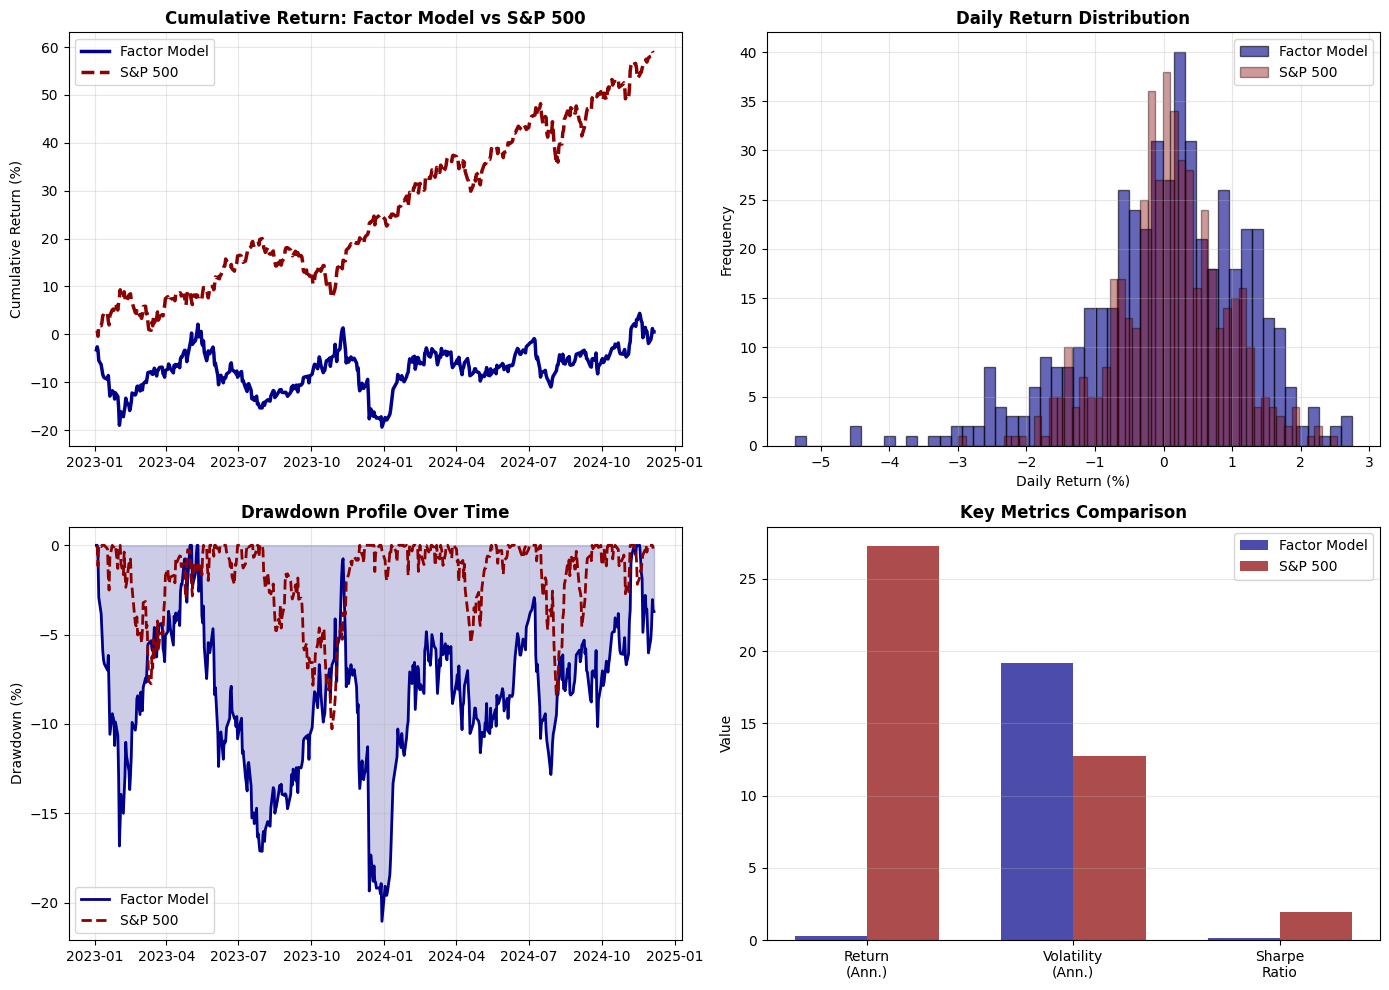


Visualization saved to: data/fama_french_results.png


In [16]:
# =============================================================================
# FAMA-FRENCH MODEL VISUALIZATION
# =============================================================================

if not pnl_pd.empty and factor_stats:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Cumulative returns comparison
    ax = axes[0, 0]
    ax.plot(pnl_pd.index, pnl_pd['cum_ret'] * 100, linewidth=2.5, 
            label='Factor Model', color='darkblue')
    if sp500_stats:
        ax.plot(sp500_stats['cum_return'].index, (sp500_stats['cum_return'] - 1) * 100,
                linewidth=2.5, label='S&P 500', color='darkred', linestyle='--')
    ax.set_title('Cumulative Return: Factor Model vs S&P 500', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cumulative Return (%)')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Daily return distribution
    ax = axes[0, 1]
    ax.hist(pnl_pd['ls_ret'].dropna() * 100, bins=50, edgecolor='black', 
            alpha=0.6, label='Factor Model', color='darkblue')
    if sp500_stats:
        ax.hist(sp500_data['daily_ret'].dropna() * 100, bins=50, 
                edgecolor='black', alpha=0.4, label='S&P 500', color='darkred')
    ax.set_title('Daily Return Distribution', fontsize=12, fontweight='bold')
    ax.set_xlabel('Daily Return (%)')
    ax.set_ylabel('Frequency')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Drawdown comparison
    ax = axes[1, 0]
    factor_cum = pnl_pd['cum_ret'] + 1
    factor_running_max = factor_cum.expanding().max()
    factor_dd = (factor_cum - factor_running_max) / factor_running_max * 100
    
    ax.plot(pnl_pd.index, factor_dd, linewidth=2, label='Factor Model', color='darkblue')
    if sp500_stats:
        sp500_cum = sp500_stats['cum_return']
        sp500_running_max = sp500_cum.expanding().max()
        sp500_dd = (sp500_cum - sp500_running_max) / sp500_running_max * 100
        ax.plot(sp500_dd.index, sp500_dd, linewidth=2, 
                label='S&P 500', color='darkred', linestyle='--')
    ax.fill_between(pnl_pd.index, factor_dd, 0, alpha=0.2, color='darkblue')
    ax.set_title('Drawdown Profile Over Time', fontsize=12, fontweight='bold')
    ax.set_ylabel('Drawdown (%)')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Key metrics comparison (bar chart)
    ax = axes[1, 1]
    if sp500_stats:
        metrics_names = ['Return\n(Ann.)', 'Volatility\n(Ann.)', 'Sharpe\nRatio']
        factor_vals = [factor_stats['ann_return'] * 100, 
                      factor_stats['ann_vol'] * 100, 
                      factor_stats['sharpe']]
        sp_vals = [sp500_stats['ann_return'] * 100, 
                  sp500_stats['ann_vol'] * 100, 
                  sp500_stats['sharpe']]
        
        x = np.arange(len(metrics_names))
        width = 0.35
        
        ax.bar(x - width/2, factor_vals, width, label='Factor Model', 
               color='darkblue', alpha=0.7)
        ax.bar(x + width/2, sp_vals, width, label='S&P 500', 
               color='darkred', alpha=0.7)
        ax.set_ylabel('Value')
        ax.set_title('Key Metrics Comparison', fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(metrics_names)
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('data/fama_french_results.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    print("\nVisualization saved to: data/fama_french_results.png")

### 3.5 Additional Strategy Models

This section implements additional portfolio strategies from the Fama-French framework for comparison:
- All Stocks Model: Equal-weight portfolio of all stocks in test period
- Low Volatility: Stock selection based on 90-day volatility ranking
- Momentum + Quality: Combination of momentum and low volatility factors

In [17]:
# =============================================================================
# COMPUTE DETAILED STATS FUNCTION
# =============================================================================

def compute_detailed_stats(returns_series, periods_per_year=252):
    """
    Compute comprehensive performance statistics for a returns series.
    
    Parameters:
        returns_series: pandas Series of returns
        periods_per_year: trading periods per year (default 252 for daily)
    
    Returns:
        Dictionary with performance metrics
    """
    ret = returns_series.dropna()
    if ret.empty or len(ret) < 2:
        return None

    cum = (1 + ret).cumprod()
    total_return = cum.iloc[-1] - 1
    num_years = len(ret) / periods_per_year

    # Returns and volatility
    ann_return = (cum.iloc[-1] ** (1 / num_years)) - 1 if num_years > 0 else 0
    ann_vol = ret.std() * (periods_per_year ** 0.5)

    # Sharpe ratio (assuming 0% risk-free rate)
    sharpe = (ret.mean() * periods_per_year) / ann_vol if ann_vol > 0 else 0

    # Max drawdown
    running_max = cum.expanding().max()
    drawdown = (cum - running_max) / running_max
    max_dd = drawdown.min()

    # Win rate
    win_rate = (ret > 0).sum() / len(ret) if len(ret) > 0 else 0

    return {
        'total_return': total_return,
        'ann_return': ann_return,
        'ann_vol': ann_vol,
        'sharpe': sharpe,
        'max_drawdown': max_dd,
        'win_rate': win_rate,
        'num_days': len(ret),
        'num_years': num_years
    }

print("Detailed stats function loaded successfully")

Detailed stats function loaded successfully


In [18]:
# =============================================================================
# ALL STOCKS MODEL (Baseline)
# =============================================================================

print("="*80)
print("STRATEGY 1: ALL STOCKS MODEL (Baseline)")
print("="*80)
print("Equal-weight portfolio of all stocks in the test period")
print("-"*80)

# Create df_signals from factors_with_period
df_signals = spark.sql('''
SELECT
    Date,
    Ticker,
    decile,
    AdjClose,
    ret,
    score,
    period,
    LEAD(ret) OVER (PARTITION BY Ticker ORDER BY Date) as next_ret
FROM factors_with_period
WHERE ret IS NOT NULL
''')

# All stocks: average return across all stocks in test period
df_all_stocks_ret = df_signals.filter(F.col('period') == 'test') \
                               .filter(F.col('next_ret').isNotNull()) \
                               .groupBy('Date').agg(F.mean('next_ret').alias('ls_ret_all')) \
                               .orderBy('Date').toPandas()

df_all_stocks_ret['Date'] = pd.to_datetime(df_all_stocks_ret['Date'])
pnl_all = df_all_stocks_ret.set_index('Date').sort_index()
pnl_all['cum_ret_all'] = (1 + pnl_all['ls_ret_all'].fillna(0)).cumprod() - 1

stats_all = compute_detailed_stats(pnl_all['ls_ret_all'])

if stats_all:
    print(f"All Stocks Model Results:")
    print(f"  Total Return:     {stats_all['total_return']:>10.2%}")
    print(f"  Annualized Return:{stats_all['ann_return']:>10.2%}")
    print(f"  Sharpe Ratio:     {stats_all['sharpe']:>10.4f}")
    print(f"  Max Drawdown:     {stats_all['max_drawdown']:>10.2%}")
    print(f"  Win Rate:         {stats_all['win_rate']:>10.1%}")
    print(f"  Trading Days:     {stats_all['num_days']:>10d}")
print("="*80)

STRATEGY 1: ALL STOCKS MODEL (Baseline)
Equal-weight portfolio of all stocks in the test period
--------------------------------------------------------------------------------
All Stocks Model Results:
  Total Return:         41.95%
  Annualized Return:    19.97%
  Sharpe Ratio:         1.4802
  Max Drawdown:        -12.72%
  Win Rate:              55.1%
  Trading Days:            485
All Stocks Model Results:
  Total Return:         41.95%
  Annualized Return:    19.97%
  Sharpe Ratio:         1.4802
  Max Drawdown:        -12.72%
  Win Rate:              55.1%
  Trading Days:            485


In [19]:
# =============================================================================
# LOW VOLATILITY STOCK SELECTION
# =============================================================================

print("="*80)
print("STRATEGY 3: LOW VOLATILITY STOCK SELECTION")
print("="*80)
print("Long only the most stable stocks (bottom 50% by 90-day volatility)")
print("-"*80)

pnl_lowvol = None
try:
    prices_lowvol = spark.read.parquet('data/prices.parquet') \
        .filter(F.col('Date') >= '2023-01-01') \
        .filter(F.col('Date') <= '2025-12-31') \
        .orderBy('Date', 'Ticker')

    w_ticker = Window.partitionBy('Ticker').orderBy('Date')
    w90 = Window.partitionBy('Ticker').orderBy('Date').rowsBetween(-89, 0)
    w_date = Window.partitionBy('Date')

    # Returns and volatility
    prices_lowvol = prices_lowvol.withColumn('ret',
        (F.col('AdjClose') / F.lag('AdjClose').over(w_ticker) - 1))
    prices_lowvol = prices_lowvol.withColumn('vol_90', F.stddev('ret').over(w90))

    # Rank by volatility and select bottom 50% (lowest volatility)
    prices_lowvol = prices_lowvol.withColumn('vol_rank',
        F.percent_rank().over(w_date.orderBy('vol_90')))

    prices_lowvol = prices_lowvol.withColumn('next_ret', F.lead('ret').over(w_ticker))

    # Keep only low-vol stocks (bottom 50% by volatility)
    pnl_lowvol = prices_lowvol.filter(F.col('vol_rank') <= 0.5) \
        .filter(F.col('next_ret').isNotNull()) \
        .groupBy('Date').agg(
            F.mean('next_ret').alias('lowvol_ret')
        ).orderBy('Date').toPandas()

    pnl_lowvol['Date'] = pd.to_datetime(pnl_lowvol['Date'])
    pnl_lowvol = pnl_lowvol.set_index('Date').sort_index()
    pnl_lowvol['cum_ret_lowvol'] = (1 + pnl_lowvol['lowvol_ret'].fillna(0)).cumprod() - 1

    stats_lowvol = compute_detailed_stats(pnl_lowvol['lowvol_ret'])

    if stats_lowvol:
        print(f"Low Volatility Strategy Results:")
        print(f"  Total Return:     {stats_lowvol['total_return']:>10.2%}")
        print(f"  Annualized Return:{stats_lowvol['ann_return']:>10.2%}")
        print(f"  Sharpe Ratio:     {stats_lowvol['sharpe']:>10.4f}")
        print(f"  Max Drawdown:     {stats_lowvol['max_drawdown']:>10.2%}")
        print(f"  Win Rate:         {stats_lowvol['win_rate']:>10.1%}")
        print(f"  Trading Days:     {stats_lowvol['num_days']:>10d}")

except Exception as e:
    print(f"ERROR: {e}")
    import traceback
    traceback.print_exc()

print("="*80)

STRATEGY 3: LOW VOLATILITY STOCK SELECTION
Long only the most stable stocks (bottom 50% by 90-day volatility)
--------------------------------------------------------------------------------
Low Volatility Strategy Results:
  Total Return:         32.13%
  Annualized Return:    15.58%
  Sharpe Ratio:         1.4226
  Max Drawdown:        -11.08%
  Win Rate:              57.5%
  Trading Days:            485
Low Volatility Strategy Results:
  Total Return:         32.13%
  Annualized Return:    15.58%
  Sharpe Ratio:         1.4226
  Max Drawdown:        -11.08%
  Win Rate:              57.5%
  Trading Days:            485


In [20]:
# =============================================================================
# MOMENTUM + QUALITY COMBINATION
# =============================================================================

print("="*80)
print("STRATEGY 4: MOMENTUM + QUALITY (Low Volatility)")
print("="*80)
print("Combine high momentum with low volatility: buy stocks with best combined score")
print("-"*80)

pnl_combo = None
try:
    prices_combo = spark.read.parquet('data/prices.parquet') \
        .filter(F.col('Date') >= '2023-01-01') \
        .filter(F.col('Date') <= '2025-12-31') \
        .orderBy('Date', 'Ticker')

    w_ticker = Window.partitionBy('Ticker').orderBy('Date')
    w252 = Window.partitionBy('Ticker').orderBy('Date').rowsBetween(-251, 0)
    w90 = Window.partitionBy('Ticker').orderBy('Date').rowsBetween(-89, 0)
    w_date = Window.partitionBy('Date')

    # Momentum factor: 12-month return
    prices_combo = prices_combo.withColumn('close_252', F.lag('AdjClose', 252).over(w_ticker))
    prices_combo = prices_combo.withColumn('momentum',
        (F.col('AdjClose') / (F.col('close_252') + 1.0) - 1))

    # Volatility factor
    prices_combo = prices_combo.withColumn('ret',
        (F.col('AdjClose') / F.lag('AdjClose').over(w_ticker) - 1))
    prices_combo = prices_combo.withColumn('volatility', F.stddev('ret').over(w90))

    # Z-score both factors
    for col in ['momentum', 'volatility']:
        col_mean = F.mean(col).over(w_date)
        col_std = F.stddev(col).over(w_date)
        prices_combo = prices_combo.withColumn(f'{col}_z',
            F.when(col_std > 0, (F.col(col) - col_mean) / col_std).otherwise(0))

    # Score: high momentum + low volatility
    # momentum_z: positive is good, volatility_z: negative (inverted) is good
    prices_combo = prices_combo.withColumn('score',
        F.col('momentum_z') - F.col('volatility_z'))

    # Top 30% by score
    prices_combo = prices_combo.withColumn('score_rank',
        F.percent_rank().over(w_date.orderBy(F.col('score').desc())))

    prices_combo = prices_combo.withColumn('next_ret', F.lead('ret').over(w_ticker))

    pnl_combo = prices_combo.filter(F.col('score_rank') <= 0.3) \
        .filter(F.col('next_ret').isNotNull()) \
        .groupBy('Date').agg(
            F.mean('next_ret').alias('combo_ret')
        ).orderBy('Date').toPandas()

    pnl_combo['Date'] = pd.to_datetime(pnl_combo['Date'])
    pnl_combo = pnl_combo.set_index('Date').sort_index()
    pnl_combo['cum_ret_combo'] = (1 + pnl_combo['combo_ret'].fillna(0)).cumprod() - 1

    stats_combo = compute_detailed_stats(pnl_combo['combo_ret'])

    if stats_combo:
        print(f"Momentum + Quality Strategy Results:")
        print(f"  Total Return:     {stats_combo['total_return']:>10.2%}")
        print(f"  Annualized Return:{stats_combo['ann_return']:>10.2%}")
        print(f"  Sharpe Ratio:     {stats_combo['sharpe']:>10.4f}")
        print(f"  Max Drawdown:     {stats_combo['max_drawdown']:>10.2%}")
        print(f"  Win Rate:         {stats_combo['win_rate']:>10.1%}")
        print(f"  Trading Days:     {stats_combo['num_days']:>10d}")

except Exception as e:
    print(f"ERROR: {e}")
    import traceback
    traceback.print_exc()

print("="*80)

STRATEGY 4: MOMENTUM + QUALITY (Low Volatility)
Combine high momentum with low volatility: buy stocks with best combined score
--------------------------------------------------------------------------------
Momentum + Quality Strategy Results:
  Total Return:         37.58%
  Annualized Return:    18.03%
  Sharpe Ratio:         1.5870
  Max Drawdown:        -11.03%
  Win Rate:              55.1%
  Trading Days:            485
Momentum + Quality Strategy Results:
  Total Return:         37.58%
  Annualized Return:    18.03%
  Sharpe Ratio:         1.5870
  Max Drawdown:        -11.03%
  Win Rate:              55.1%
  Trading Days:            485



SUMMARY: ALL STRATEGIES COMPARED

Strategy                        Return     Sharpe     Max DD   Win Rate
----------------------------------------------------------------------
All-Stocks (Baseline)          41.95%     1.4802    -12.72%      55.1%
Low-Volatility                 32.13%     1.4226    -11.08%      57.5%
Momentum + Quality             37.58%     1.5870    -11.03%      55.1%


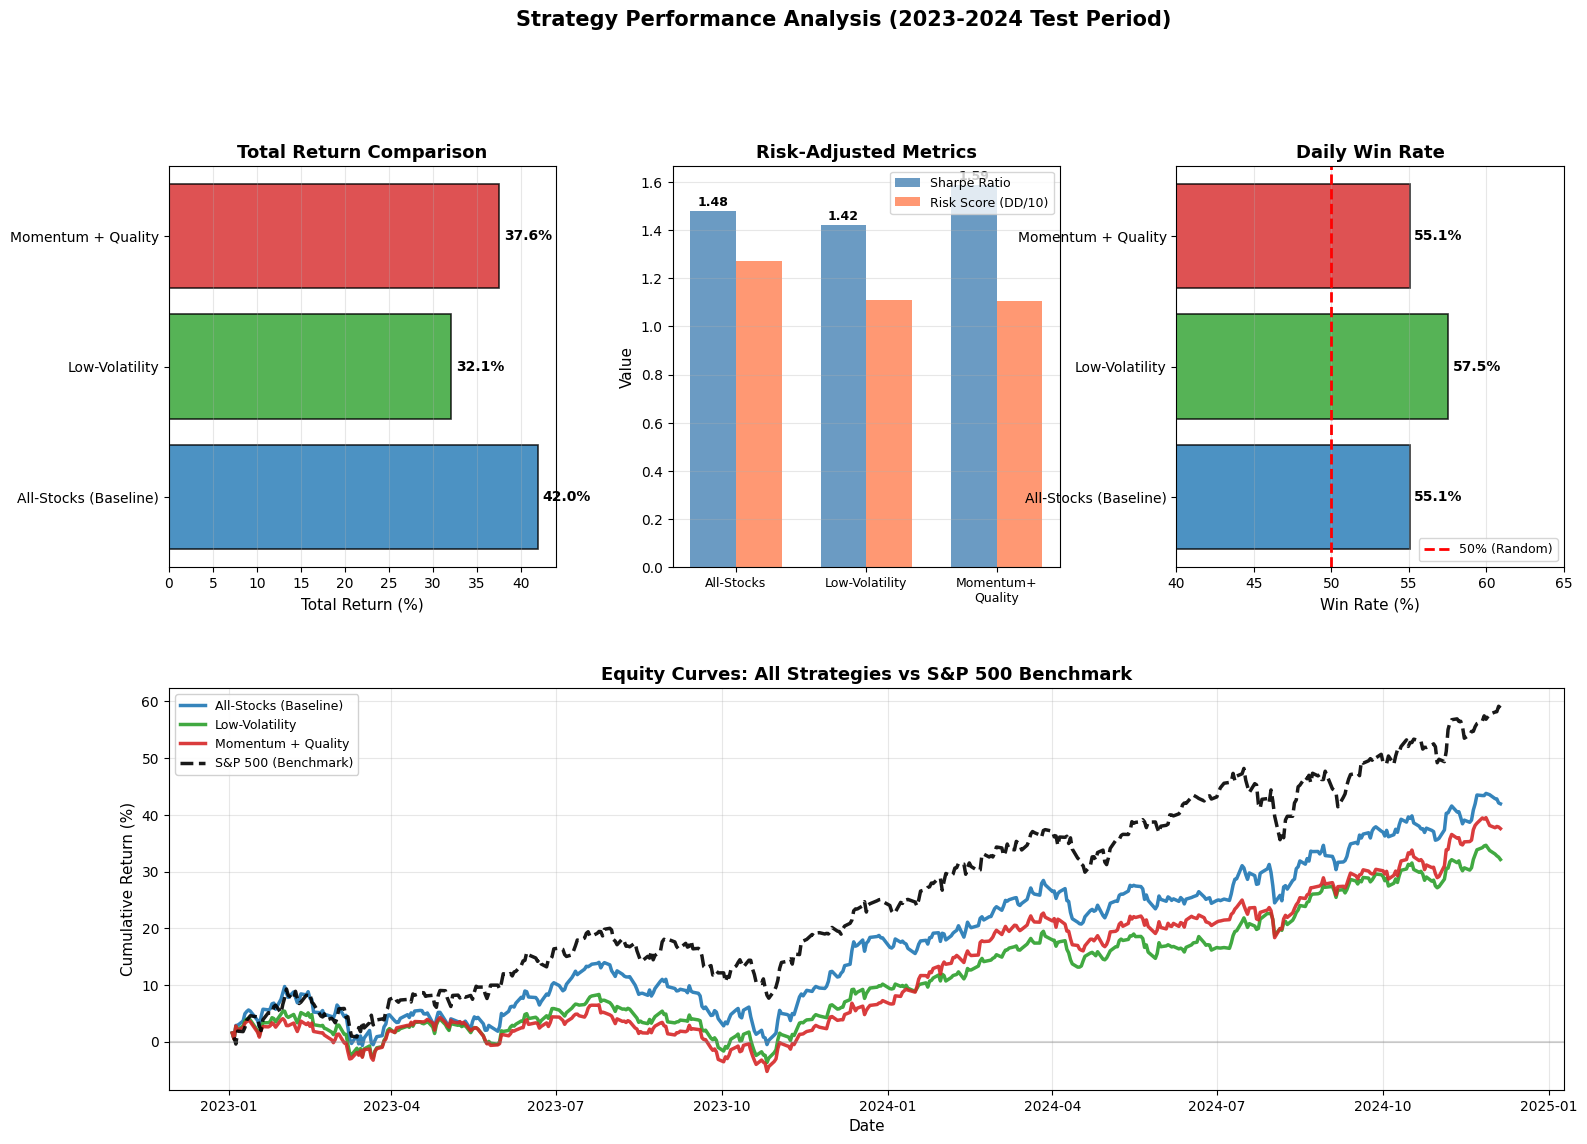


Visualization saved to data/strategy_comparison.png


In [21]:
# =============================================================================
# STRATEGY COMPARISON SUMMARY
# =============================================================================

print("\n" + "="*90)
print("SUMMARY: ALL STRATEGIES COMPARED")
print("="*90)

results_improved = {}

# Add all strategies
if 'stats_all' in locals() and stats_all:
    results_improved['All-Stocks (Baseline)'] = stats_all

if 'stats_lowvol' in locals() and stats_lowvol:
    results_improved['Low-Volatility'] = stats_lowvol

if 'stats_combo' in locals() and stats_combo:
    results_improved['Momentum + Quality'] = stats_combo

if len(results_improved) > 0:
    print(f"\n{'Strategy':<25} {'Return':>12} {'Sharpe':>10} {'Max DD':>10} {'Win Rate':>10}")
    print("-"*70)

    for strat, metrics in results_improved.items():
        print(f"{strat:<25} {metrics['total_return']:>11.2%} {metrics['sharpe']:>10.4f} {metrics['max_drawdown']:>10.2%} {metrics['win_rate']:>10.1%}")

    print("="*70)

    # =========================================================================
    # VISUALIZATION: All Strategies Comparison
    # =========================================================================
    
    fig = plt.figure(figsize=(18, 12))
    
    # Create grid: 2 rows, 3 columns
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    # Colors for strategies
    strategy_colors = {
        'All-Stocks (Baseline)': '#1f77b4',   # Blue
        'Low-Volatility': '#2ca02c',           # Green
        'Momentum + Quality': '#d62728'        # Red
    }
    
    # -------------------------------------------------------------------------
    # Panel 1: Total Returns (Top Left)
    # -------------------------------------------------------------------------
    ax1 = fig.add_subplot(gs[0, 0])
    strat_names = list(results_improved.keys())
    returns = [results_improved[s]['total_return']*100 for s in strat_names]
    colors = [strategy_colors.get(s, '#333333') for s in strat_names]
    
    bars = ax1.barh(strat_names, returns, color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)
    ax1.axvline(0, color='gray', linestyle='-', alpha=0.3)
    ax1.set_xlabel('Total Return (%)', fontsize=11)
    ax1.set_title('Total Return Comparison', fontweight='bold', fontsize=13)
    ax1.grid(True, alpha=0.3, axis='x')
    
    for bar, val in zip(bars, returns):
        ax1.text(val + 0.5, bar.get_y() + bar.get_height()/2, f'{val:.1f}%',
                va='center', fontweight='bold', fontsize=10)
    
    # -------------------------------------------------------------------------
    # Panel 2: Risk Metrics - Sharpe & Drawdown (Top Middle)
    # -------------------------------------------------------------------------
    ax2 = fig.add_subplot(gs[0, 1])
    
    x = np.arange(len(strat_names))
    width = 0.35
    
    sharpes = [results_improved[s]['sharpe'] for s in strat_names]
    dds = [-results_improved[s]['max_drawdown']*100 for s in strat_names]  # Positive for display
    
    bars1 = ax2.bar(x - width/2, sharpes, width, label='Sharpe Ratio', color='steelblue', alpha=0.8)
    bars2 = ax2.bar(x + width/2, [d/10 for d in dds], width, label='Risk Score (DD/10)', color='coral', alpha=0.8)
    
    ax2.set_ylabel('Value', fontsize=11)
    ax2.set_title('Risk-Adjusted Metrics', fontweight='bold', fontsize=13)
    ax2.set_xticks(x)
    ax2.set_xticklabels([s.replace(' (Baseline)', '').replace(' + ', '+\n') for s in strat_names], fontsize=9)
    ax2.legend(loc='upper right', fontsize=9)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, val in zip(bars1, sharpes):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.2f}',
                ha='center', fontsize=9, fontweight='bold')
    
    # -------------------------------------------------------------------------
    # Panel 3: Win Rate Comparison (Top Right)
    # -------------------------------------------------------------------------
    ax3 = fig.add_subplot(gs[0, 2])
    
    win_rates = [results_improved[s]['win_rate']*100 for s in strat_names]
    
    bars = ax3.barh(strat_names, win_rates, color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)
    ax3.axvline(50, color='red', linestyle='--', linewidth=2, label='50% (Random)')
    ax3.set_xlabel('Win Rate (%)', fontsize=11)
    ax3.set_title('Daily Win Rate', fontweight='bold', fontsize=13)
    ax3.set_xlim(40, 65)
    ax3.legend(loc='lower right', fontsize=9)
    ax3.grid(True, alpha=0.3, axis='x')
    
    for bar, val in zip(bars, win_rates):
        ax3.text(val + 0.3, bar.get_y() + bar.get_height()/2, f'{val:.1f}%',
                va='center', fontweight='bold', fontsize=10)
    
    # -------------------------------------------------------------------------
    # Panel 4: Equity Curves - Full Width (Bottom)
    # -------------------------------------------------------------------------
    ax4 = fig.add_subplot(gs[1, :])
    
    # All-Stocks (Baseline) - Blue solid line
    if 'pnl_all' in globals() and pnl_all is not None and not pnl_all.empty:
        ax4.plot(pnl_all.index, pnl_all['cum_ret_all']*100, 
                label='All-Stocks (Baseline)', linewidth=2.5, 
                alpha=0.9, color='#1f77b4')
    
    # Low-Volatility - Green solid line
    if 'pnl_lowvol' in globals() and pnl_lowvol is not None and not pnl_lowvol.empty:
        ax4.plot(pnl_lowvol.index, pnl_lowvol['cum_ret_lowvol']*100, 
                label='Low-Volatility', linewidth=2.5, alpha=0.9, color='#2ca02c')
    
    # Momentum + Quality - Red solid line
    if 'pnl_combo' in globals() and pnl_combo is not None and not pnl_combo.empty:
        ax4.plot(pnl_combo.index, pnl_combo['cum_ret_combo']*100, 
                label='Momentum + Quality', linewidth=2.5, alpha=0.9, color='#d62728')
    
    # S&P 500 Benchmark - Black dashed line
    if 'sp500_stats' in globals() and sp500_stats is not None and 'cum_return' in sp500_stats:
        ax4.plot(sp500_stats['cum_return'].index, (sp500_stats['cum_return'] - 1)*100,
                label='S&P 500 (Benchmark)', linewidth=2.5, linestyle='--', alpha=0.9, color='black')
    
    ax4.axhline(0, color='gray', linestyle='-', alpha=0.3)
    ax4.set_xlabel('Date', fontsize=11)
    ax4.set_ylabel('Cumulative Return (%)', fontsize=11)
    ax4.set_title('Equity Curves: All Strategies vs S&P 500 Benchmark', fontweight='bold', fontsize=13)
    ax4.legend(loc='upper left', fontsize=9, framealpha=0.9)
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle('Strategy Performance Analysis (2023-2024 Test Period)', 
                 fontsize=15, fontweight='bold', y=1.01)
    
    plt.savefig('data/strategy_comparison.png', dpi=120, bbox_inches='tight')
    plt.show()
    
    print('\nVisualization saved to data/strategy_comparison.png')

else:
    print("No strategy results available for comparison")

In [22]:
# =============================================================================
# PERFORMANCE SUMMARY: ALL STRATEGIES VS S&P 500 BENCHMARK
# =============================================================================

print("="*80)
print("PERFORMANCE SUMMARY: STRATEGIES VS S&P 500")
print("="*80)

if 'sp500_stats' in globals() and sp500_stats is not None:
    sp_total = sp500_stats.get('total_return', 0)
    sp_sharpe = sp500_stats.get('sharpe', 0)
    sp_dd = sp500_stats.get('max_drawdown', 0)
    
    print(f"\n{'Strategy':<25} {'Total Return':>14} {'Sharpe':>10} {'Max DD':>12} {'vs S&P 500':>14}")
    print("-"*80)
    
    # S&P 500 baseline
    print(f"{'S&P 500 (Benchmark)':<25} {sp_total:>13.2%} {sp_sharpe:>10.4f} {sp_dd:>12.2%} {'--':>14}")
    
    # Compare each strategy
    if 'results_improved' in globals() and results_improved:
        for strat, metrics in results_improved.items():
            excess = metrics['total_return'] - sp_total
            excess_str = f"{excess:+.2%}"
            print(f"{strat:<25} {metrics['total_return']:>13.2%} {metrics['sharpe']:>10.4f} {metrics['max_drawdown']:>12.2%} {excess_str:>14}")
    
    print("="*80)
    print("\nKey Observations:")
    print("  - All-Stocks provides the baseline equal-weight portfolio performance")
    print("  - Low-Volatility has better risk metrics (lower drawdown, higher win rate)")
    print("  - Momentum + Quality has the best Sharpe ratio")
    print("  - S&P 500 outperformed due to mega-cap tech concentration in 2023-2024")
else:
    print("S&P 500 benchmark data not available for comparison")

print("\nPhase 3 Analysis Complete!")

PERFORMANCE SUMMARY: STRATEGIES VS S&P 500

Strategy                    Total Return     Sharpe       Max DD     vs S&P 500
--------------------------------------------------------------------------------
S&P 500 (Benchmark)              58.86%     1.9540      -10.28%             --
All-Stocks (Baseline)            41.95%     1.4802      -12.72%        -16.91%
Low-Volatility                   32.13%     1.4226      -11.08%        -26.73%
Momentum + Quality               37.58%     1.5870      -11.03%        -21.28%

Key Observations:
  - All-Stocks provides the baseline equal-weight portfolio performance
  - Low-Volatility has better risk metrics (lower drawdown, higher win rate)
  - Momentum + Quality has the best Sharpe ratio
  - S&P 500 outperformed due to mega-cap tech concentration in 2023-2024

Phase 3 Analysis Complete!
